# **Problem 1**

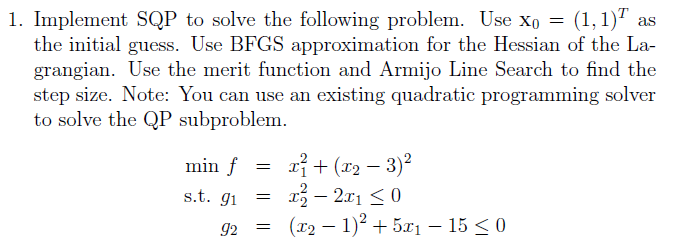

Solution for this problem is: X=(1.06041690,1.45633564)


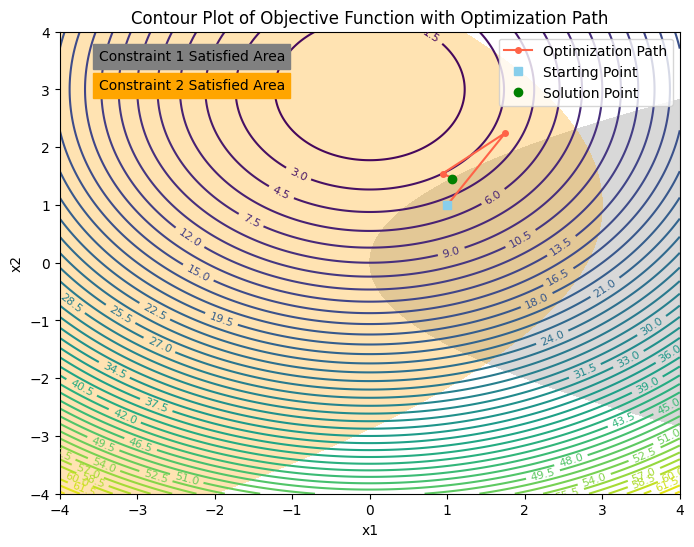

In [22]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import copy

def f_obj(x):
    return x[0][0] ** 2 + (x[1][0] - 3) ** 2
def df_obj(x):
    return np.array([[2 * x[0][0], 2 * (x[1][0] - 3)]])
def dg(x):
    return np.array([[-2, 2 * x[1][0]], [5, 2 * (x[1][0] - 1)]])
def g(x):
    return np.array([[x[1][0] ** 2 - 2 * x[0][0]], [(x[1][0] - 1) ** 2 + 5 * x[0][0] - 15]])
def LineSearch(x, s, M, u_old, iter):
    t = 0.3
    p = 1
    if iter == 0:
        u = abs(M)
    else:
        u = np.zeros((2, 1))
        u[0] = max(abs(M[0]), 0.5 * (u_old[0] + abs(M[0])))
        u[1] = max(abs(M[1]), 0.5 * (u_old[1] + abs(M[1])))
    dg_da_1 = 0 if g(x)[0, :] <= 0 else np.matmul(dg(x)[0, :], s)
    dg_da_2 = 0 if g(x)[1, :] <= 0 else np.matmul(dg(x)[1, :], s)
    dF_da = np.matmul(df_obj(x), s) + (u[0, :] * dg_da_1 + u[1, :] * dg_da_2)
    def F_p(x, u, p, s):
        g1 = max(0, g(x + p*s)[0, :])
        g2 = max(0, g(x + p*s)[1, :])
        F = f_obj(x + p*s) + (u[0, :] * g1 + u[1, :] * g2)
        return F
    phi = lambda x, u, p, t, dF_da: F_p(x, u, 0, 0) + p * t * dF_da
    while phi(x, u, p, t, dF_da) < F_p(x, u, p, s):
        p = 0.8 * p
    return p, u
def solve_sqp(x, U):
    A_0 = dg(x)
    B_0 = g(x)
    M0 = np.zeros((B_0.shape[0], 1))
    M = []
    status = []
    while True:
        if len(status) == 0:
            mat = U
            s_M = np.matmul(np.linalg.inv(mat), -df_obj(x).T)
            s = s_M[:2, :]
            M = []
        if len(status) != 0:
            if len(status) == 1:
                A = A_0[status[0], :].reshape(1, -1)
                b = B_0[status[0], :]
            if len(status) == 2:
                A = copy.deepcopy(A_0)
                b = copy.deepcopy(B_0)
            mat = np.vstack((np.hstack((U, A.T)), np.hstack((A, np.zeros((A.shape[0], A.shape[0]))))))
            s_M = np.matmul(np.linalg.inv(mat), np.vstack((-df_obj(x).T, -b)))
            s = s_M[:2, :]
            M = s_M[2:, :]
            if len(M) == 1:
                M0[0] = s_M[2:3, :]
            if len(M) == 2:
                M0[0] = s_M[2:3, :]
                M0[1] = s_M[3:, :]
        sqp_con = np.round((np.matmul(A_0, s.reshape(-1, 1)) + B_0))
        M_chck = 0
        if len(M) == 0:
            M_chck = 1
        elif min(M) > 0:
            M_chck = 1
        else:
            id_M = np.argmin(np.array(M))
            M.remove(min(M))
            status.pop(id_M)

        if np.max(sqp_con) <= 0:
            if M_chck == 1:
                return s, M0
        else:
            i = np.argmax(sqp_con)
            status.append(i)
            status = np.unique(np.array(status)).tolist()
def BFGS(U, x, dx, s, M):
    del_L = (df_obj(x) + np.matmul(M.T, dg(x))) - (df_obj(x - dx) + np.matmul(M.T, dg(x - dx)))
    temp = np.matmul(np.matmul(dx.T, U), dx)
    if np.matmul((dx).T, del_L.T) >= 0.2 * np.matmul(np.matmul((dx).T, U), (dx)):
        thita = 1
    else:
        thita = 0.8 * temp / (temp - np.matmul(dx.T, del_L.T))
    Y = thita * del_L.T + (1 - thita) * np.matmul(U, dx)
    U_new = U + np.matmul(Y, Y.T) / np.matmul(Y.T, s) - np.matmul(np.matmul(U, s), np.matmul(s.T, U)) / np.matmul(np.matmul(s.T, U), s)
    return U_new

eps = 1e-3
x = np.array([[1.], [1.]])
U = np.eye(x.shape[0])
M_old = np.zeros((x.shape[0], 1))
iter = 0
delta_norm = np.linalg.norm(df_obj(x) + np.matmul(M_old.T, dg(x)))
u_old = np.zeros((2, 1))
soln1 = [x[0][0]]
soln2 = [x[1][0]]

while delta_norm > eps:
    s, M_new = solve_sqp(x, U)
    p, u_new = LineSearch(x, s, M_old, u_old, iter)
    u_old = u_new
    dx = p * s
    x = x + dx
    U = BFGS(U, x, dx, s, M_new)
    iter = iter + 1
    delta_norm = np.linalg.norm(df_obj(x) + np.matmul(M_new.T, dg(x)))
    M_old = M_new
    soln1.append(x[0][0])
    soln2.append(x[1][0])

X1 = np.linspace(-4, 4, 400)
X2 = np.linspace(-4, 4, 400)
x1, x2 = np.meshgrid(X1, X2)
N = np.array([f_obj(np.array([[x1i], [x2i]])) for x2i in X2 for x1i in X1]).reshape(x1.shape)
N1 = np.array([g(np.array([[x1i], [x2i]]))[0,0] for x2i in X2 for x1i in X1]).reshape(x1.shape)
N2 = np.array([g(np.array([[x1i], [x2i]]))[1,0] for x2i in X2 for x1i in X1]).reshape(x1.shape)
print('Solution for this problem is: X=({:.8f},{:.8f})'.format(soln1[-1], soln2[-1]))
plt.figure(figsize=(8, 6))
cp = plt.contour(x1, x2, N, levels=50, cmap='viridis')
plt.clabel(cp, inline=True, fontsize=8)
plt.plot(soln1, soln2, 'o-', color='tomato', label='Optimization Path', markersize=4)
plt.plot(soln1[0], soln2[0], 's', color='skyblue', label='Starting Point', markersize=6)
plt.plot(soln1[-1], soln2[-1], 'o', color='green', label='Solution Point', markersize=6)
plt.contourf(x1, x2, N1, levels=[-np.inf, 0], alpha=0.3, colors='grey')
plt.contourf(x1, x2, N2, levels=[-np.inf, 0], alpha=0.3, colors='orange')
plt.text(-3.5, 3.5, 'Constraint 1 Satisfied Area', backgroundcolor='grey')
plt.text(-3.5, 3, 'Constraint 2 Satisfied Area', backgroundcolor='orange')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Contour Plot of Objective Function with Optimization Path')
plt.legend()
plt.show()

# **Problem 2**

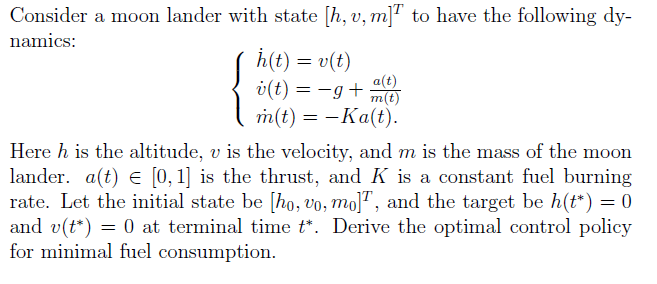

differential_evolution step 1: f(x)= 9.34238e+09
Optimal thrust profile: [8.74507796e-01 9.60050562e-01 8.35000042e-01 8.03924456e-01
 9.63563184e-01 2.43342403e-01 8.23441514e-02 4.61583713e-01
 1.17127209e-01 4.24698121e-01 2.09630532e-01 8.80753060e-01
 6.31452995e-01 7.80480997e-01 1.29876516e-01 6.13168838e-01
 1.04504779e-01 6.60737493e-02 2.47397567e-01 1.07037755e-01
 2.04666098e-01 3.93218807e-02 9.55524891e-02 1.74336552e-01
 6.85743880e-01 5.13980621e-01 9.51434249e-02 3.69230747e-01
 9.15859060e-01 1.74232853e-01 3.88399226e-02 4.89194089e-01
 3.22970248e-01 7.21320522e-01 8.40668327e-01 2.59654120e-01
 3.91382747e-01 2.39195685e-01 2.16669539e-01 2.67957400e-01
 6.44729839e-01 2.36382939e-01 1.59059614e-01 4.64047083e-01
 1.52302532e-01 4.22156033e-01 8.53785933e-02 4.91094239e-01
 8.70780061e-01 3.18632896e-01 2.20690391e-01 6.22418637e-01
 6.86141088e-01 6.98158472e-01 6.83707217e-01 9.75746933e-02
 3.01092057e-02 5.44218071e-01 8.53799175e-01 4.31017341e-01
 9.68213012e

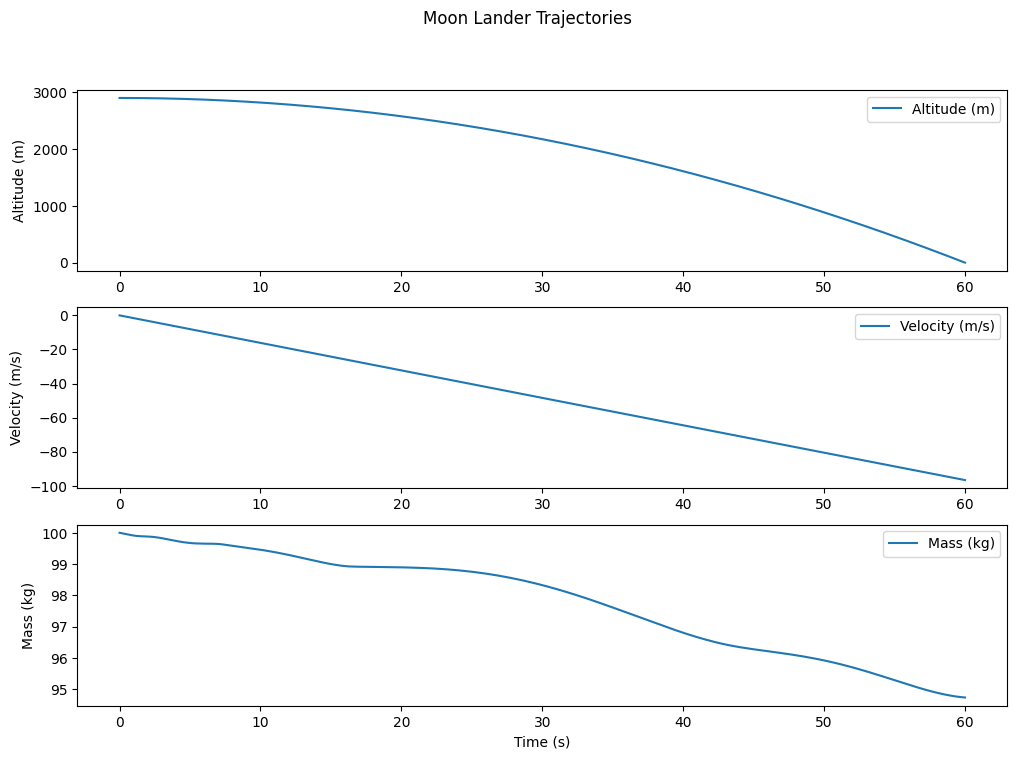

In [6]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import differential_evolution
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

# Constants
g = 1.62  # gravitational acceleration on the moon in m/s^2
K = 0.1   # fuel consumption rate in kg/s

h0, v0, m0 = 2900, 0, 100

t_final = 60
N = 200
dt = t_final / N
time = np.linspace(0, t_final, N)

def dynamics(t, y, a_func):
    h, v, m = y
    a = a_func(t)
    dhdt = v
    dvdt = -g + a/m if m > 0 else 0
    dmdt = -K * a if m > 0 else 0
    return [dhdt, dvdt, dmdt]

def objective(a):
    a_func = interp1d(time, a, kind='zero', bounds_error=False, fill_value=(a[0], a[-1]))
    sol = solve_ivp(lambda t, y: dynamics(t, y, a_func), [0, t_final], [h0, v0, m0], t_eval=[t_final])
    final_mass = sol.y[2, -1]
    final_h = sol.y[0, -1]
    final_v = sol.y[1, -1]
    penalty = (1e6 * abs(final_h)**2 if final_h > 0 else 0) + (1e6 * abs(final_v)**2)
    return -final_mass + penalty

a_bounds = [(0, 1)] * N


result = differential_evolution(
    objective,
    a_bounds,
    strategy='best1bin',
    maxiter=1000,
    tol=0.01,
    disp=True,
    polish=False,
    updating='deferred',
    workers=-1
)

# Checking if the optimization was successful
if result.success:
    a_optimal = result.x
    a_func_optimal = interp1d(time, a_optimal, kind='zero', bounds_error=False, fill_value=(a_optimal[0], a_optimal[-1]))

    sol = solve_ivp(lambda t, y: dynamics(t, y, a_func_optimal), [0, t_final], [h0, v0, m0], t_eval=time)

    print("Optimal thrust profile:", a_optimal)

    print("Final altitude:", sol.y[0][-1])
    print("Final velocity:", sol.y[1][-1])
    print("Final mass:", sol.y[2][-1])

    plt.figure(figsize=(12, 8))

    plt.subplot(3, 1, 1)
    plt.plot(sol.t, sol.y[0], label='Altitude (m)')
    plt.ylabel('Altitude (m)')
    plt.legend()

    plt.subplot(3, 1, 2)
    plt.plot(sol.t, sol.y[1], label='Velocity (m/s)')
    plt.ylabel('Velocity (m/s)')
    plt.legend()

    plt.subplot(3, 1, 3)
    plt.plot(sol.t, sol.y[2], label='Mass (kg)')
    plt.xlabel('Time (s)')
    plt.ylabel('Mass (kg)')
    plt.legend()

    plt.suptitle('Moon Lander Trajectories')
    plt.show()
else:
    print("Optimization failed:", result.message)



Not able to safely land the moon lander, though I tried different ways it's always crash landing (altitued<0 and velocity at max).